perhaps add more graphs if can get time to.

In [1]:
# importing necessary packages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cross_validation, tree, metrics, ensemble

%matplotlib inline

In [2]:
# reading in datasets

county_facts = pd.read_csv("../datasets/2016-us-election/county_facts.csv")
county_facts_dictionary = pd.read_csv("../datasets/2016-us-election/county_facts_dictionary.csv")
results = pd.read_csv('../datasets/2016-us-election/primary_results.csv')

In [3]:
county_facts_dictionary # a dictionary of all column headers

,column_name,description
0,PST045214,"Population, 2014 estimate"
1,PST040210,"Population, 2010 (April 1) estimates base"
2,PST120214,"Population, percent change - April 1, 2010 to ..."
3,POP010210,"Population, 2010"
4,AGE135214,"Persons under 5 years, percent, 2014"
5,AGE295214,"Persons under 18 years, percent, 2014"
6,AGE775214,"Persons 65 years and over, percent, 2014"
7,SEX255214,"Female persons, percent, 2014"
8,RHI125214,"White alone, percent, 2014"
9,RHI225214,"Black or African American alone, percent, 2014"


In [4]:
results[['fips', 'state_abbreviation', 'candidate', 'votes']].head().to_clipboard()

In [5]:
results[['fips', 'candidate', 'state_abbreviation', 'votes']].head()

,fips,candidate,state_abbreviation,votes
0,1001.0,Bernie Sanders,AL,544
1,1001.0,Hillary Clinton,AL,2387
2,1003.0,Bernie Sanders,AL,2694
3,1003.0,Hillary Clinton,AL,5290
4,1005.0,Bernie Sanders,AL,222


In [6]:
county_facts = county_facts.rename(columns={ # renaming columns for ease of reference/use
        'PST045214': 'pop_2014_est', 'PST040210': 'pop_2010_est', 'PST120214': 'pop_chg', 'POP010210': 'pop_2010',
        'AGE135214': 'under_5_pct', 'AGE295214': 'under_18_pct', 'AGE775214': 'above_64_pct', 'SEX255214': 'female_pct',
        'RHI125214': 'white', 'RHI1225214': 'black', 'RHI325214': 'native', 'RHI425214': 'asian', 'RHI525214': 'pacific',
        'RHI625214': 'multi', 'RHI725214': 'hispanic', 'RHI825214': 'white_nonhisp', 'POP645213': 'same_house_1+',
        'POP645213': 'foreign_born_09-13', 'POP815213': 'nonenglish_home', 'EDU635213': 'highschool',
        'EDU685213': 'bachelors', 'VET605213': 'veterans_09-13', 'HSG010214': 'housing_units', 'HSG445213': 'home_rate',
        'HSD310213': 'household_size', 'INC910213': 'percap_income_1yr', 'INC110213': 'median_income',
        'PVY020213': 'pct_below_poverty', 'BZA010213': 'priv_nonfarm', 'SBO001207': 'num_firms',
        'SBO315207': 'black_firm_pct', 'SBO115207': 'native_firm_pct', 'SBO215207': 'asian_firm_pct',
        'SBO515207': 'pacific_firm_pct', 'SBO415207': 'hispanic_firm_pct', 'SBO015207': 'female_firm_pct',
        'MAN450207': 'mfct_shipments_07', 'RTN130207': 'rsales_07', 'RTN131207': 'rsales_pcap_07',
        'AFN120207': 'service_sales_07', 'BPS030214': 'bldng_permits', 'LND110210': 'land_area',
        'POP060210': 'pop_per_m2', 'WTN220207': 'merch_sales', 'LFE305213': 'travel_time', 'HSG096213': 'multi_unit_pct',
        'HSG495213': 'median_val_ownerhousing', 'RHI225214': 'black_alone'
    })

In [7]:
# dictionary (with some additions) from: 
# http://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
states = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AS': 'American Samoa',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'GU': 'Guam',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MP': 'Northern Mariana Islands',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NA': 'National',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'PR': 'Puerto Rico',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'US': 'United States',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VI': 'Virgin Islands',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}

In [8]:
inv_states = {v: k for k, v in states.items()} # inverting the states dictionary for use later

In [9]:
results[results.county == 'Fayette']; # previewing the results dataset

In [10]:
raw = county_facts.merge(results, on=['fips', 'state_abbreviation'], how='inner',) # merging results with county demographics

In [11]:
raw.info() # no null vales in dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17479 entries, 0 to 17478
Data columns (total 60 columns):
fips                       17479 non-null int64
area_name                  17479 non-null object
state_abbreviation         17479 non-null object
pop_2014_est               17479 non-null int64
pop_2010_est               17479 non-null int64
pop_chg                    17479 non-null float64
pop_2010                   17479 non-null int64
under_5_pct                17479 non-null float64
under_18_pct               17479 non-null float64
above_64_pct               17479 non-null float64
female_pct                 17479 non-null float64
white                      17479 non-null float64
black_alone                17479 non-null float64
native                     17479 non-null float64
asian                      17479 non-null float64
pacific                    17479 non-null float64
multi                      17479 non-null float64
hispanic                   17479 non-null float64
w

In [12]:
raw.tail() # previewing new dataset; note that we have each candidate's voter information by county

,fips,area_name,state_abbreviation,pop_2014_est,pop_2010_est,pop_chg,pop_2010,under_5_pct,under_18_pct,above_64_pct,...,service_sales_07,bldng_permits,land_area,pop_per_m2,state,county,party,candidate,votes,fraction_votes
17474,56041,Uinta County,WY,20904,21118,-1.0,21118,7.6,29.8,11.0,...,35497,40,2081.26,10.1,Wyoming,Uinta,Democrat,Hillary Clinton,4,0.444
17475,56043,Washakie County,WY,8322,8533,-2.5,8533,5.5,23.9,20.1,...,10175,4,2238.55,3.8,Wyoming,Washakie,Democrat,Bernie Sanders,1,0.333
17476,56043,Washakie County,WY,8322,8533,-2.5,8533,5.5,23.9,20.1,...,10175,4,2238.55,3.8,Wyoming,Washakie,Democrat,Hillary Clinton,2,0.667
17477,56045,Weston County,WY,7201,7208,-0.1,7208,6.5,21.6,18.1,...,7520,1,2398.09,3.0,Wyoming,Weston,Democrat,Bernie Sanders,1,0.500
17478,56045,Weston County,WY,7201,7208,-0.1,7208,6.5,21.6,18.1,...,7520,1,2398.09,3.0,Wyoming,Weston,Democrat,Hillary Clinton,1,0.500


In [13]:
## TODO:
## (!) Vary predictors/gather a score for predictive power
## (2) determine wisdom behind splitting training set. 
## (3) how will we determine voter preference in general elecion? Will need model for how voters will vote when first
## or second choice is missing
## (4) attempt random forest

### First set of predictors

Testing our model on a small subset of predictors. We use our 'intuition' to select a few predictors and see how well we do at predicting our target variable.

In [14]:
# an example set of predictors
X = ['pop_chg', 'above_64_pct', 'female_pct', 'white', 'bachelors', 'pct_below_poverty']
y = 'fraction_votes'

X_d = raw[raw.party == 'Democrat'][X]
y_d = raw[raw.party == 'Democrat'][y]

X_r = raw[raw.party == 'Republican'][X]
y_r = raw[raw.party == 'Republican'][y]

In [15]:
X_dtrain, X_dtest, y_dtrain, y_dtest = cross_validation.train_test_split(X_d, y_d, test_size=0.3)
X_rtrain, X_rtest, y_rtrain, y_rtest = cross_validation.train_test_split(X_r, y_r, test_size=0.3)

In [16]:
model = tree.DecisionTreeRegressor()

In [17]:
model.fit(X_dtrain, y_dtrain)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [18]:
train_yd_hat = model.predict(X_dtrain)
print 'train MSE: ', np.sqrt(metrics.mean_squared_error(y_dtrain, train_yd_hat))

test_yd_hat = model.predict(X_dtest)
print 'test MSE: ', np.sqrt(metrics.mean_squared_error(y_dtest, test_yd_hat))

train MSE:  0.148073348108
test MSE:  0.308095188172


In [19]:
sorted(zip(model.feature_importances_, X_d.columns.values), reverse = True) # ranking of predictor relevance

[(0.18741132105215569, 'pct_below_poverty'),
 (0.18057023330546701, 'white'),
 (0.16993292955567915, 'bachelors'),
 (0.16521314796914954, 'female_pct'),
 (0.1639191161844189, 'above_64_pct'),
 (0.13295325193312976, 'pop_chg')]

In [20]:
model.fit(X_rtrain, y_rtrain)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [21]:
train_yr_hat = model.predict(X_rtrain)
print 'train MSE: ', np.sqrt(metrics.mean_squared_error(y_rtrain, train_yr_hat))

test_yr_hat = model.predict(X_rtest)
print 'test MSE: ', np.sqrt(metrics.mean_squared_error(y_rtest, test_yr_hat))

train MSE:  0.166649485348
test MSE:  0.263448977755


In [22]:
sorted(zip(model.feature_importances_, X_r.columns.values), reverse = True) # ranking of predictor relevance

[(0.18866207802328983, 'pop_chg'),
 (0.18746765655387343, 'white'),
 (0.18059574639323447, 'bachelors'),
 (0.15997750418879683, 'above_64_pct'),
 (0.1462762586186723, 'pct_below_poverty'),
 (0.13702075622213319, 'female_pct')]

In [23]:
correlations = ['pop_chg', 'above_64_pct', 'female_pct', 'white', 'bachelors', 'pct_below_poverty']

In [24]:
# plt.figure()
# plt.hist(raw)

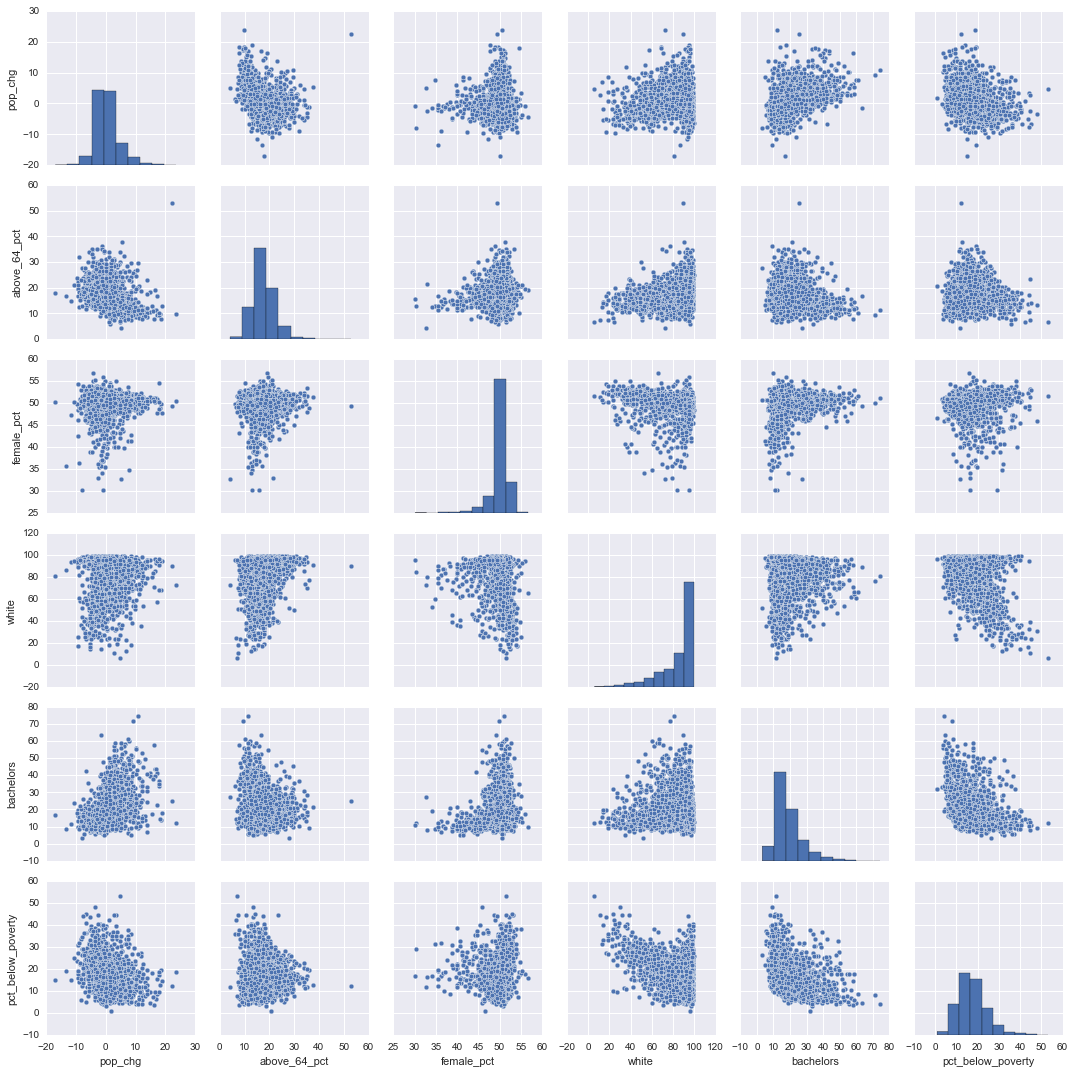

In [25]:
sns.pairplot(raw[correlations])

### Second Set

Below, we test model on all non-object datatypes within dataset. We drop collinear and redundant columns. We will utilize the built in ranking of predictors to determine what will be used in our later predictions

In [26]:
numeric = raw.select_dtypes(exclude=['object']) # selecting only numeric types from dataset

X_2 = numeric.columns.drop(['fraction_votes', 'votes', 'fips']) # dropping redundant values

X_2d = raw[raw.party == 'Democrat'][X_2] # predicting democratic choice
y_2d = raw[raw.party == 'Democrat'][y]

X_2r = raw[raw.party == 'Republican'][X_2] # predicting democratic choice
y_2r = raw[raw.party == 'Republican'][y]

In [27]:
X_2dtrain, X_2dtest, y_2dtrain, y_2dtest = cross_validation.train_test_split(X_2d, y_2d, test_size=0.3)
X_2rtrain, X_2rtest, y_2rtrain, y_2rtest = cross_validation.train_test_split(X_2r, y_2r, test_size=0.3)

In [28]:
model = tree.DecisionTreeRegressor()
model.fit(X_2dtrain, y_2dtrain)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [29]:
train_yd_hat = model.predict(X_2dtrain)
print 'train MSE: ', np.sqrt(metrics.mean_squared_error(y_2dtrain, train_yd_hat))

test_yd_hat = model.predict(X_2dtest)
print 'test MSE: ', np.sqrt(metrics.mean_squared_error(y_dtest, test_yd_hat))

train MSE:  0.149516404174
test MSE:  0.247724676862


In [30]:
train_2yr_hat = model.predict(X_2rtrain)
print 'train MSE: ', np.sqrt(metrics.mean_squared_error(y_2rtrain, train_2yr_hat))

test_2yr_hat = model.predict(X_2rtest)
print 'test MSE: ', np.sqrt(metrics.mean_squared_error(y_2rtest, test_2yr_hat))

train MSE:  0.321947049348
test MSE:  0.32437631406


#### Results:
- our MSE for the test democratic dataset decreased by 5 percentatge points
- MSE for both training and test data for republicans increased 
- not sure what is the cause for this change

#### Next:
- what are most important feaures?
- how do they relate to one another?
- what are characteristics of voters?

In [31]:
model.fit(X_2dtrain, y_2dtrain);
sorted(zip(model.feature_importances_, X_2d.columns.values), reverse = True)[:10] # ranking of top 10 predictors

[(0.072366263029891117, 'highschool'),
 (0.054737114705286603, 'white'),
 (0.046687239570251553, 'percap_income_1yr'),
 (0.045999793941791732, 'bachelors'),
 (0.045102612073768096, 'multi_unit_pct'),
 (0.043509033850384189, 'black_alone'),
 (0.035139542899286655, 'median_income'),
 (0.034629034929938095, 'female_firm_pct'),
 (0.030066606378137815, 'pop_per_m2'),
 (0.028487008224105635, 'under_18_pct')]

#### Top 10 predictors for democratic choice:
1. white
2. high school or higher
3. travel time
4. black owned firm percentage
5. median income
6. population per square mile
7. percent of homes that are multiunit
8. home where English is not first language
9. percent of population under 18
10. percent of white, non hispanic

In [32]:
model.fit(X_2rtrain, y_2rtrain);
sorted(zip(model.feature_importances_, X_2r.columns.values), reverse = True)[:10] # ranking of top 10 predictors

[(0.07169412931245496, 'land_area'),
 (0.068042228820407294, 'highschool'),
 (0.045774183353768171, 'pop_per_m2'),
 (0.044025961671490539, 'travel_time'),
 (0.031723098272061871, 'pop_chg'),
 (0.031397787571345877, 'rsales_pcap_07'),
 (0.031351949058259859, 'under_18_pct'),
 (0.030446112831112, 'white_nonhisp'),
 (0.030419184926370434, 'merch_sales'),
 (0.026674306663253287, 'median_val_ownerhousing')]

#### Top 10 predictors for republican choice
1. travel time to work
2. land area
3. population per square mile
4. high school or higher
5. median value of owner occupied homes
6. percap income
7. hispanic
8. housing units in multiunit structures
9. bachelors or higher
10. percent below poverty

### Non - Split dataset
not splitting based on dem/rep

In [33]:
numeric = raw.select_dtypes(exclude=['object']) # selecting only numeric types from dataset

X_col = numeric.columns.drop(['fraction_votes', 'votes', 'fips']) # dropping redundant values
y_col = 'fraction_votes'

X = raw[X_col] # predicting democratic choice
y= raw[y_col]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y)
train_yhat = model.predict(X_train)

model.fit(X_train, y_train)

print 'train MSE: ', np.sqrt(metrics.mean_squared_error(y_train, train_yhat))

test_yhat = model.predict(X_test)
print 'test MSE: ', np.sqrt(metrics.mean_squared_error(y_test, test_yhat))

train MSE:  0.239880950343
test MSE:  0.256815240476


out test MSE has actually dropped down using the entire data set. Will try using the top predictors.

In [34]:
sorted(zip(model.feature_importances_, X.columns.values), reverse = True)[:10] # ranking of top 10 predictors

[(0.10918580107718454, 'highschool'),
 (0.092225074175467561, 'land_area'),
 (0.050374805421052396, 'pop_per_m2'),
 (0.038130125953105026, 'merch_sales'),
 (0.034324877706818371, 'black_alone'),
 (0.033326929518325436, 'travel_time'),
 (0.033029839680839029, 'home_rate'),
 (0.032911009770910576, 'hispanic'),
 (0.031591901881462423, 'pct_below_poverty'),
 (0.030388807840679977, 'pop_chg')]

In [35]:
X_col = ['highschool', 'land_area', 'white_nonhisp', 'merch_sales', 'housing_units', 'travel_time', 'multi_unit_pct',
        'median_val_ownerhousing', 'nonenglish_home', 'veterans_09-13', 'pop_chg', 'travel_time']

X = raw[X_col]
y = raw['fraction_votes']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y)

model.fit(X_train, y_train)

train_yhat = model.predict(X_train)
print 'train MSE: ', np.sqrt(metrics.mean_squared_error(y_train, train_yhat))

test_yhat = model.predict(X_test)
print 'test MSE: ', np.sqrt(metrics.mean_squared_error(y_test, test_yhat))

train MSE:  0.203699386705
test MSE:  0.258713197408


### What are characteristics between the two parties?

In [36]:
def winner(row): # creating a target variable for a primary win (greatest percentage of votes)
    if row['rank'] == 1:
        val = 1
    elif row['rank'] == 1.5:
        val = 1
    else:
        val = 0
    return val        

In [37]:
raw['rank'] = raw.groupby(by=['fips', 'party'])['fraction_votes'].rank(ascending=False) 
# grouping by county, party and finding rank

raw['primary_win'] = raw.apply(winner, axis=1) # creating a column for top place in primary

In [38]:
trump_df = raw[raw.candidate == 'Donald Trump']
clinton_df = raw[raw.candidate == 'Hillary Clinton']

In [39]:
features = ['highschool', 'land_area', 'white_nonhisp', 'merch_sales', 'housing_units', 'travel_time',
            'multi_unit_pct', 'median_val_ownerhousing', 'nonenglish_home', 'veterans_09-13', 'pop_chg', 'travel_time']

trump_char = trump_df[trump_df['primary_win'] == 1][features].describe()

clinton_char = clinton_df[clinton_df['primary_win'] == 1][features].describe()

In [40]:
trump_char

,highschool,land_area,white_nonhisp,merch_sales,housing_units,travel_time,multi_unit_pct,median_val_ownerhousing,nonenglish_home,veterans_09-13,pop_chg,travel_time
count,1996.000000,1996.000000,1996.000000,1.996000e+03,1.996000e+03,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000
mean,83.653958,915.380581,77.404960,1.104915e+06,4.306003e+04,24.013627,11.687275,128709.919840,7.612675,7009.404309,-0.052806,24.013627
std,6.670024,1383.833128,20.030871,6.458476e+06,1.280612e+05,5.339151,8.667916,74597.434775,9.918625,17149.838455,3.523358,5.339151
min,54.000000,2.530000,3.700000,0.000000e+00,2.520000e+02,9.800000,0.000000,19900.000000,0.000000,31.000000,-9.700000,9.800000
25%,78.900000,403.962500,65.375000,0.000000e+00,6.324000e+03,20.500000,6.000000,83500.000000,2.500000,1048.500000,-2.200000,20.500000
50%,84.800000,564.295000,85.050000,3.696750e+04,1.294400e+04,23.600000,9.300000,106300.000000,4.200000,2156.500000,-0.700000,23.600000
75%,88.900000,814.277500,93.800000,2.346150e+05,3.081750e+04,27.325000,14.925000,150125.000000,8.200000,5618.250000,1.600000,27.325000
max,99.000000,20056.940000,98.600000,1.984358e+08,3.482516e+06,42.800000,89.700000,781900.000000,91.300000,331642.000000,23.700000,42.800000


In [41]:
clinton_char

,highschool,land_area,white_nonhisp,merch_sales,housing_units,travel_time,multi_unit_pct,median_val_ownerhousing,nonenglish_home,veterans_09-13,pop_chg,travel_time
count,1669.000000,1669.000000,1669.000000,1.669000e+03,1.669000e+03,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000
mean,82.143919,842.841150,70.158418,1.648762e+06,5.341846e+04,24.075494,11.951947,125650.449371,10.841043,8336.581186,0.564290,24.075494
std,7.090999,1255.374013,21.361909,9.260060e+06,1.529927e+05,5.343439,9.613614,79227.691381,13.822393,19884.163723,4.211124,5.343439
min,45.000000,2.000000,3.100000,0.000000e+00,1.860000e+02,9.800000,0.000000,35500.000000,0.000000,6.000000,-13.400000,9.800000
25%,77.300000,412.750000,56.500000,0.000000e+00,5.930000e+03,20.400000,5.800000,80800.000000,2.800000,961.000000,-2.100000,20.400000
50%,82.600000,575.370000,73.400000,4.235300e+04,1.268800e+04,23.700000,9.100000,102800.000000,5.400000,2092.000000,-0.100000,23.700000
75%,87.800000,850.620000,89.100000,2.708650e+05,3.597200e+04,27.500000,15.200000,143600.000000,12.300000,6672.000000,2.600000,27.500000
max,97.300000,20056.940000,97.900000,2.054788e+08,3.482516e+06,42.800000,98.500000,828100.000000,95.600000,331642.000000,23.700000,42.800000


### Next Steps:
- attempt random forest model
- determine how to improve predictive power
- try other methods of cross-validation
- attempt to predict general election (model not robust enough currently...)

### Random Forest

In [42]:
# numeric = raw.select_dtypes(exclude=['object']) # selecting only numeric types from dataset

# X_col = numeric.columns.drop(['fraction_votes', 'votes', 'fips']) # dropping redundant values
# y_col = 'fraction_votes'

# X = raw[X_col]
# y = raw[y_col]

# train_X, test_X, train_y, test_y = cross_validation.train_test_split(X, y, test_size = 0.3)

In [43]:
# model = ensemble.RandomForestClassifier(n_estimators = 1000, max_features = 4, min_samples_leaf = 5, oob_score = True)

# model.fit(train_X, train_y)

### A model to predict general election results

In [44]:
losses = raw[((raw['candidate'] != 'Hillary Clinton') & (raw['candidate'] != 'Donald Trump')) & (raw['rank'] == 1.0)] 

In [45]:
# battleground states per http://www.politico.com/2016-election/swing-states
# will be able to focus our predictions on these states to predict outcome
battle_ground = {
    'CO': 'Colorado',
    'FL': 'Florida',
    'IA': 'Iowa',
    'MI': 'Michigan',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NC': 'North Carolina',
    'OH': 'Ohio',
    'PA': 'Pennsylvania',
    'VA': 'Virginia',
    'WI': 'Wisconsin'
}

In [46]:
losses_battle = losses[(losses['state_abbreviation'] == 'CO') | (losses['state_abbreviation'] == 'FL') |
                                                   (losses['state_abbreviation'] == 'IA') |
                                                    (losses['state_abbreviation'] == 'MI') |
                                                     (losses['state_abbreviation'] == 'NV') |
                                                      (losses['state_abbreviation'] == 'NH') |
                                                       (losses['state_abbreviation'] == 'NC') |
                                                        (losses['state_abbreviation'] == 'OH') |
                                                         (losses['state_abbreviation'] == 'PA') |
                                                          (losses['state_abbreviation'] == 'VA') |
                                                           (losses['state_abbreviation'] == 'WI')]

### Below is a dataframe that contains losses for Donald Trump or Hillary Clinton in BattleGround counties

In [47]:
losses_battle.candidate.unique()

array(['Bernie Sanders', 'Marco Rubio', 'Ted Cruz', 'John Kasich'], dtype=object)

### Theory 1: Transitive Voter Preferences (e.g. voters vote their relative party)

In [48]:
winner = raw[((raw['candidate'] == 'Hillary Clinton') | (raw['candidate'] == 'Donald Trump')) & (raw['rank'] <= 1.5)]

In [49]:
winner.head(); # a dataframe with the results with Trump or Clinton winning.

In [50]:
# converting voters for competitors within primary to the party winners
losses_battle = losses_battle.replace(to_replace={
        'candidate': {'Bernie Sanders': 'Hillary Clinton', 'Ted Cruz': 'Donald Trump', 'Marco Rubio': 'Donald Trump',
                      'John Kasich': 'Donald Trump'}})

In [51]:
losses = losses.replace(to_replace={
        'candidate': {'Bernie Sanders': 'Hillary Clinton', 'Ted Cruz': 'Donald Trump', 'Marco Rubio': 'Donald Trump',
                      'John Kasich': 'Donald Trump'}})

In [52]:
general_tot = winner.append(losses)

In [53]:
general_battle = winner.append(losses_battle)

In [54]:
county_votes = raw.groupby(by=['fips', 'party'])['votes'].sum()

In [55]:
general_tot = general_tot.join(county_votes, on=['fips', 'party'], lsuffix='left', rsuffix='right')

In [56]:
general_tot.head()

,fips,area_name,state_abbreviation,pop_2014_est,pop_2010_est,pop_chg,pop_2010,under_5_pct,under_18_pct,above_64_pct,...,pop_per_m2,state,county,party,candidate,votesleft,fraction_votes,rank,primary_win,votesright
1,1001,Autauga County,AL,55395,54571,1.5,54571,6.0,25.2,13.8,...,91.8,Alabama,Autauga,Democrat,Hillary Clinton,2387,0.800,1.0,1,2931
3,1001,Autauga County,AL,55395,54571,1.5,54571,6.0,25.2,13.8,...,91.8,Alabama,Autauga,Republican,Donald Trump,5387,0.445,1.0,1,11839
8,1003,Baldwin County,AL,200111,182265,9.8,182265,5.6,22.2,18.7,...,114.6,Alabama,Baldwin,Democrat,Hillary Clinton,5290,0.647,1.0,1,7984
10,1003,Baldwin County,AL,200111,182265,9.8,182265,5.6,22.2,18.7,...,114.6,Alabama,Baldwin,Republican,Donald Trump,23618,0.469,1.0,1,49100
15,1005,Barbour County,AL,26887,27457,-2.1,27457,5.7,21.2,16.5,...,31.0,Alabama,Barbour,Democrat,Hillary Clinton,2567,0.906,1.0,1,2789


In [57]:
general_tot = pd.get_dummies(general_tot, columns=['party', 'candidate'], drop_first=True)

In [58]:
general_tot.head()

,fips,area_name,state_abbreviation,pop_2014_est,pop_2010_est,pop_chg,pop_2010,under_5_pct,under_18_pct,above_64_pct,...,pop_per_m2,state,county,votesleft,fraction_votes,rank,primary_win,votesright,party_Republican,candidate_Hillary Clinton
1,1001,Autauga County,AL,55395,54571,1.5,54571,6.0,25.2,13.8,...,91.8,Alabama,Autauga,2387,0.800,1.0,1,2931,0.0,1.0
3,1001,Autauga County,AL,55395,54571,1.5,54571,6.0,25.2,13.8,...,91.8,Alabama,Autauga,5387,0.445,1.0,1,11839,1.0,0.0
8,1003,Baldwin County,AL,200111,182265,9.8,182265,5.6,22.2,18.7,...,114.6,Alabama,Baldwin,5290,0.647,1.0,1,7984,0.0,1.0
10,1003,Baldwin County,AL,200111,182265,9.8,182265,5.6,22.2,18.7,...,114.6,Alabama,Baldwin,23618,0.469,1.0,1,49100,1.0,0.0
15,1005,Barbour County,AL,26887,27457,-2.1,27457,5.7,21.2,16.5,...,31.0,Alabama,Barbour,2567,0.906,1.0,1,2789,0.0,1.0


In [59]:
raw_dummy = pd.get_dummies(raw, columns=['party', 'candidate'], drop_first=True)

In [60]:
model = tree.DecisionTreeRegressor()

numeric = general_tot.select_dtypes(exclude=['object']) # selecting only numeric types from dataset

X_col = numeric.columns.drop(['fraction_votes', 'votesleft', 'votesright', 'rank', 'primary_win']) 
# dropping redundant values
y_col = 'fraction_votes'

# training set is based on primary results
train_X = raw_dummy[X_col]
train_y = raw_dummy[y_col]

# test set is consolidated down to two main candidates for each party
test_X = general_tot[X_col]
test_y = general_tot[y_col]

model.fit(train_X, train_y)
train_yhat = model.predict(train_X)
print 'train MSE: ', np.sqrt(metrics.mean_squared_error(train_y, train_yhat))

test_yhat = model.predict(test_X)
print 'test MSE: ', np.sqrt(metrics.mean_squared_error(test_y, test_yhat))

train MSE:  0.15069149991
test MSE:  0.223678787676


In [61]:
model = tree.DecisionTreeRegressor()

numeric = general_tot.select_dtypes(exclude=['object']) # selecting only numeric types from dataset

X_col = numeric.columns.drop(['fraction_votes', 'votesleft', 'votesright', 'rank', 'primary_win']) 
# dropping redundant values
y_col = 'fraction_votes'

X = general_tot[X_col]
y = general_tot[y_col]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)

model.fit(X_train, y_train)

train_yhat = model.predict(X_train)
print 'train MSE: ', np.sqrt(metrics.mean_squared_error(y_train, train_yhat))

test_yhat = model.predict(X_test)
print 'test MSE: ', np.sqrt(metrics.mean_squared_error(y_test, test_yhat))

train MSE:  1.54876314823e-18
test MSE:  0.106029031283


In [62]:
sorted(zip(model.feature_importances_, X_train.columns.values), reverse = True)[:10] # ranking of 10 predictor relevance

[(0.20386463630757196, 'fips'),
 (0.188190107196017, 'black_alone'),
 (0.14973202531159818, 'candidate_Hillary Clinton'),
 (0.084717246998148532, 'land_area'),
 (0.041692459683542953, 'multi'),
 (0.027319997002656041, 'median_val_ownerhousing'),
 (0.021367893199610376, 'housing_units'),
 (0.019675747108922892, 'bachelors'),
 (0.01679097165625364, 'foreign_born_09-13'),
 (0.013531414548811696, 'highschool')]

### MSE for test dataset is <15%
We will explore the importance of different features below

In [63]:
general_tot['win'] = general_tot.groupby(by=['fips'])['votesright'].rank(ascending=False) 

general_tot = general_tot.replace(to_replace={'win': {2: 0}})

### ##TO DO:
Apply weights based on electoral college to determine who will win the general election

In [64]:
import statsmodels.api as sm

numeric = general_tot.select_dtypes(exclude=['object']) # selecting only numeric types from dataset

X_col = numeric.columns.drop(['fraction_votes', 'votesleft', 'votesright', 'rank', 'win']) # dropping redundant values
y_col = 'win'


test_X = general_tot[['under_18_pct', 'white', 'pop_per_m2', 'household_size', 'black_firm_pct', 'highschool']]
test_y = general_tot[y_col]


logit = sm.Logit(test_y, test_X)

# model.fit(train_X, train_y)
# train_yhat = model.predict(train_X)
# print 'train MSE: ', np.sqrt(metrics.mean_squared_error(train_y, train_yhat))

# test_yhat = model.predict(test_X)
# print 'test MSE: ', np.sqrt(metrics.mean_squared_error(test_y, test_yhat))

In [65]:
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.692935
         Iterations 3


In [66]:
print result.summary()

                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                 5507
Model:                          Logit   Df Residuals:                     5501
Method:                           MLE   Df Model:                            5
Date:                Wed, 10 Aug 2016   Pseudo R-squ.:               0.0001182
Time:                        15:14:56   Log-Likelihood:                -3816.0
converged:                       True   LL-Null:                       -3816.4
                                        LLR p-value:                    0.9700
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
under_18_pct      -0.0011      0.011     -0.101      0.919        -0.022     0.020
white              0.0002      0.002      0.084      0.933        -0.004     0.004
pop_per_m2     -1.087e-06   1.51e-05

the logistic regression does not return significant results. likely a fitting error
above we need to create new column that converts count of votes to a fraction of votes column